## Metrics and evaluation - Bank Marketing Dataset

In this exercise you will create a classification model to predict whether a client will subscribe to a term deposit or not. You will evaluate the model using different metrics and techniques.

The dataset is hosted in [Kaggle](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset), although originally published by [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing)
You can also download it manually and update the `path` variable to the appropriate directory in your local environment.

Run the following cell to download the dataset using `kagglehub` package.

In [ ]:
import kagglehub
import pandas

# Download latest version
path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bank-marketing-dataset' dataset.
Path to dataset files: /kaggle/input/bank-marketing-dataset


In [ ]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer

In [ ]:
# The `path` variable points to the directory of the downloaded files.
# We are interested in the `bank.csv` file specifically.
filepath = Path(path) / Path("bank.csv")

data = pd.read_csv(filepath)

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## EDA

Let's start by exploring the dataset and understanding the features and target variable.
Here is the list of all features in the dataset:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Additionally, the description of the database in the UCI repository provides more context on each feature:

| Variable Name | Role | Type | Demographic | Description | Units | Missing Values |
|---------------|------|------|-------------|-------------|-------|----------------|
| age           | Feature | Integer | Age | | | no |
| job           | Feature | Categorical | Occupation | type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') | | no |
| marital       | Feature | Categorical | Marital Status | marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) | | no |
| education     | Feature | Categorical | Education Level | (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') | | no |
| default       | Feature | Binary | | has credit in default? | | no |
| balance       | Feature | Integer | | average yearly balance | euros | no |
| housing       | Feature | Binary | | has housing loan? | | no |
| loan          | Feature | Binary | | has personal loan? | | no |
| contact       | Feature | Categorical | | contact communication type (categorical: 'cellular','telephone') | | yes |
| day           | Feature | Date | | last contact day of the week | | no |
| month         | Feature | Date | | last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') | | no |
| duration      | Feature | Integer | | last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. | | no |
| campaign      | Feature | Integer | | number of contacts performed during this campaign and for this client (numeric, includes last contact) | | no |
| pdays         | Feature | Integer | | number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted) | | yes |
| previous      | Feature | Integer | | number of contacts performed before this campaign and for this client | | no |
| poutcome      | Feature | Categorical | | outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') | | yes |
| deposit       | Target | Binary | | has the client subscribed a term deposit? | | |


### Target variable analysis

Our target variable is `deposit`, which indicates whether a client has subscribed to a term deposit or not.

Text(0.5, 1.0, "Distribution of target variable 'deposit'")

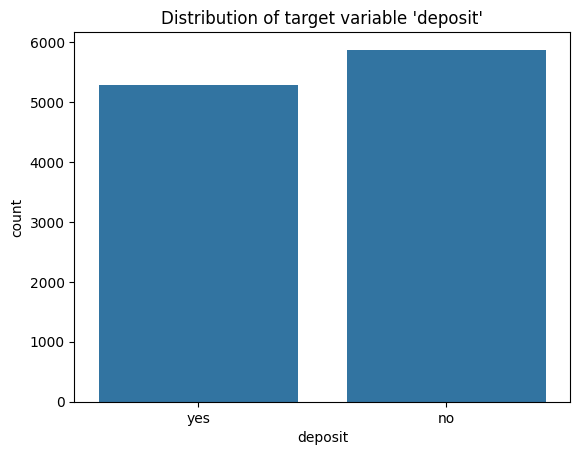

In [ ]:
sns.countplot(data=data, x="deposit")
plt.title("Distribution of target variable 'deposit'")

### Feature analysis

Let's start by understanding the descriptive statistics of the dataset.

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


We can also visualize the distribution of numerical features.

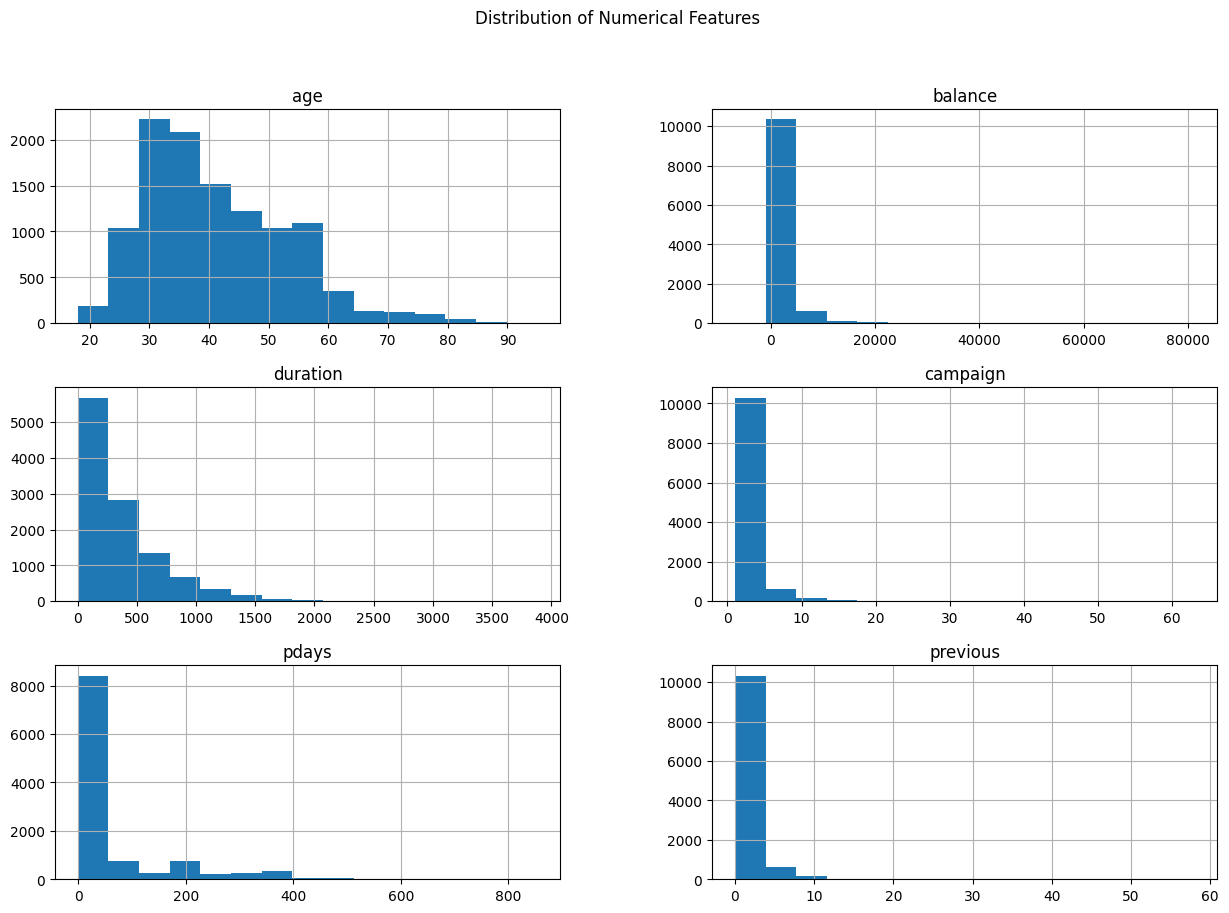

In [ ]:
numerical_features = ["age", "balance", "duration", "campaign", "pdays", "previous"]

data[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.show()

Let's also look at the distribution of categorical features. Note that we are considering day and month as categorical features for this analysis, since they have a limited number of unique values.

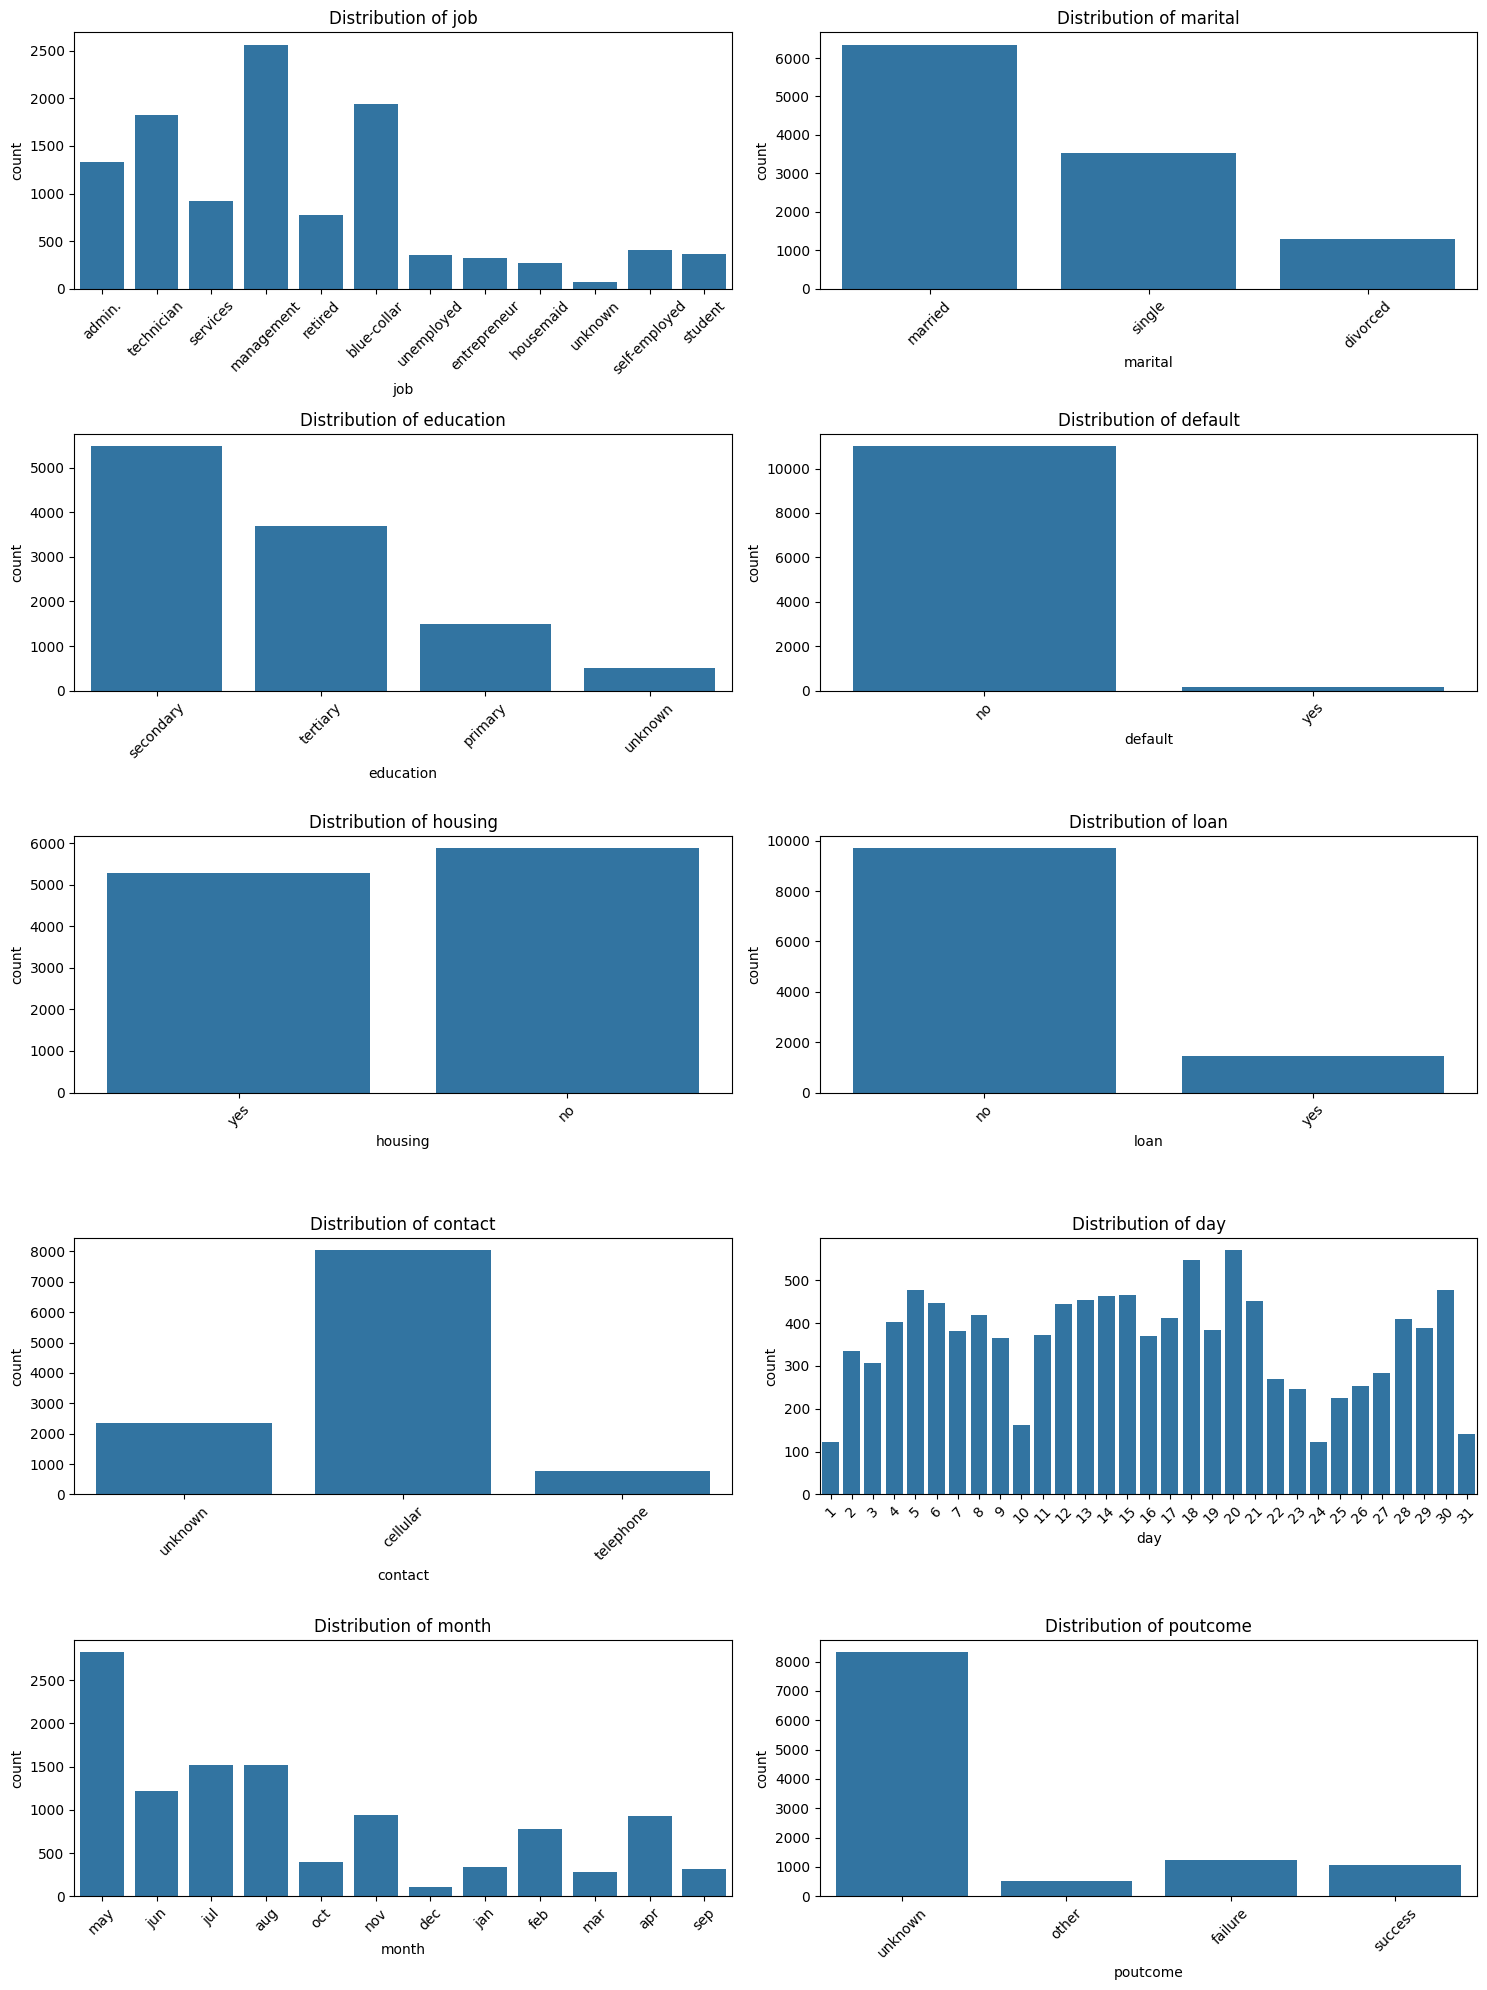

In [ ]:
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "day", "month",
                        "poutcome"]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for ax, feature in zip(axes.ravel(), categorical_features):
    sns.countplot(data=data, x=feature, ax=ax)
    ax.set_title(f"Distribution of {feature}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

We can also explore the proportion of missing values in the dataset. From the description, we know that only `contact`, `pdays`, and `poutcome` have missing values. For `contact` and `poutcome`, 'unknown' is used to denote missing values, while for `pdays`, -1 indicates that the client was not previously contacted. Let's now verify the proportion of these missing values.

Additionally, `job` and `education` also have 'unknown' values, but they are not considered missing values in the dataset description, so we will not include them in this analysis.

In [ ]:
missing_contact = (data['contact'] == 'unknown').mean() * 100
missing_pdays = (data['pdays'] == -1).mean() * 100
missing_poutcome = (data['poutcome'] == 'unknown').mean() * 100
missing_job = (data['job'] == 'unknown').mean() * 100
missing_education = (data['education'] == 'unknown').mean() * 100

print(f"Proportion of missing values in 'contact': {missing_contact:.2f}%")
print(f"Proportion of missing values in 'pdays': {missing_pdays:.2f}%")
print(f"Proportion of missing values in 'poutcome': {missing_poutcome:.2f}%")
print(f"Proportion of 'unknown' values in 'job': {missing_job:.2f}%")
print(f"Proportion of 'unknown' values in 'education': {missing_education:.2f}%")

Proportion of missing values in 'contact': 21.02%
Proportion of missing values in 'pdays': 74.57%
Proportion of missing values in 'poutcome': 74.59%
Proportion of 'unknown' values in 'job': 0.63%
Proportion of 'unknown' values in 'education': 4.45%


Let's also explore the relationship between some of the features and the target variable. For numerical features, we can use boxplots to visualize the distribution of the feature values for each class of the target variable.

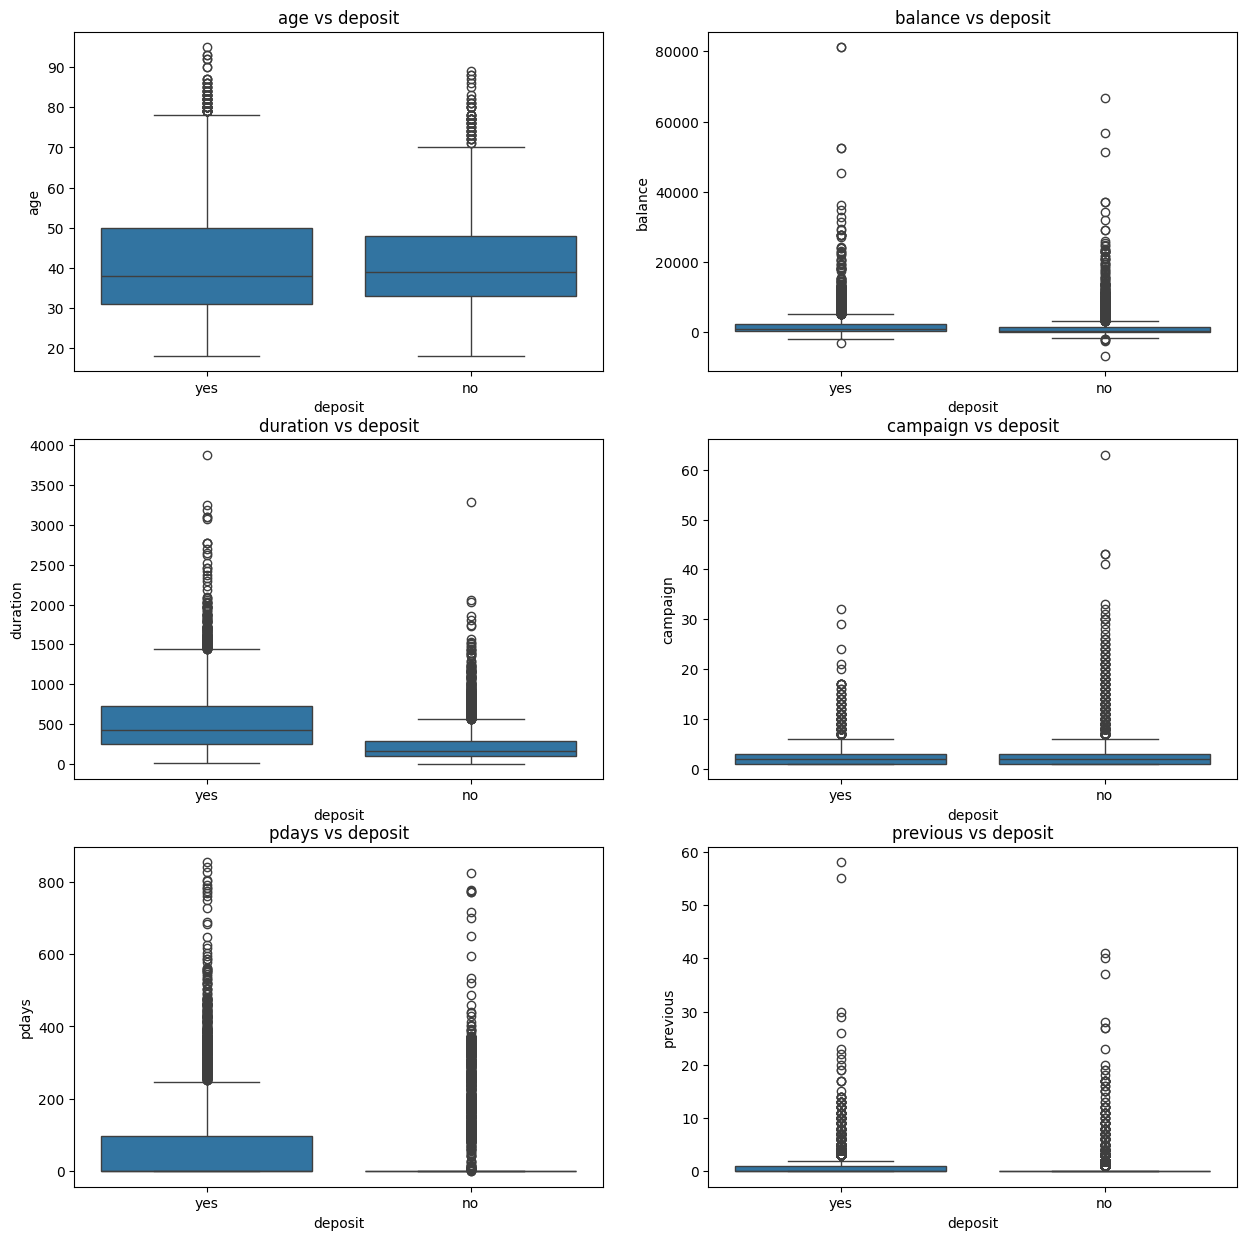

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

for ax, feature in zip(axes.ravel(), numerical_features):
    sns.boxplot(data=data, x="deposit", y=feature, ax=ax)
    ax.set_title(f"{feature} vs deposit")

We can also use countplots to visualize the relationship between categorical features and the target variable.

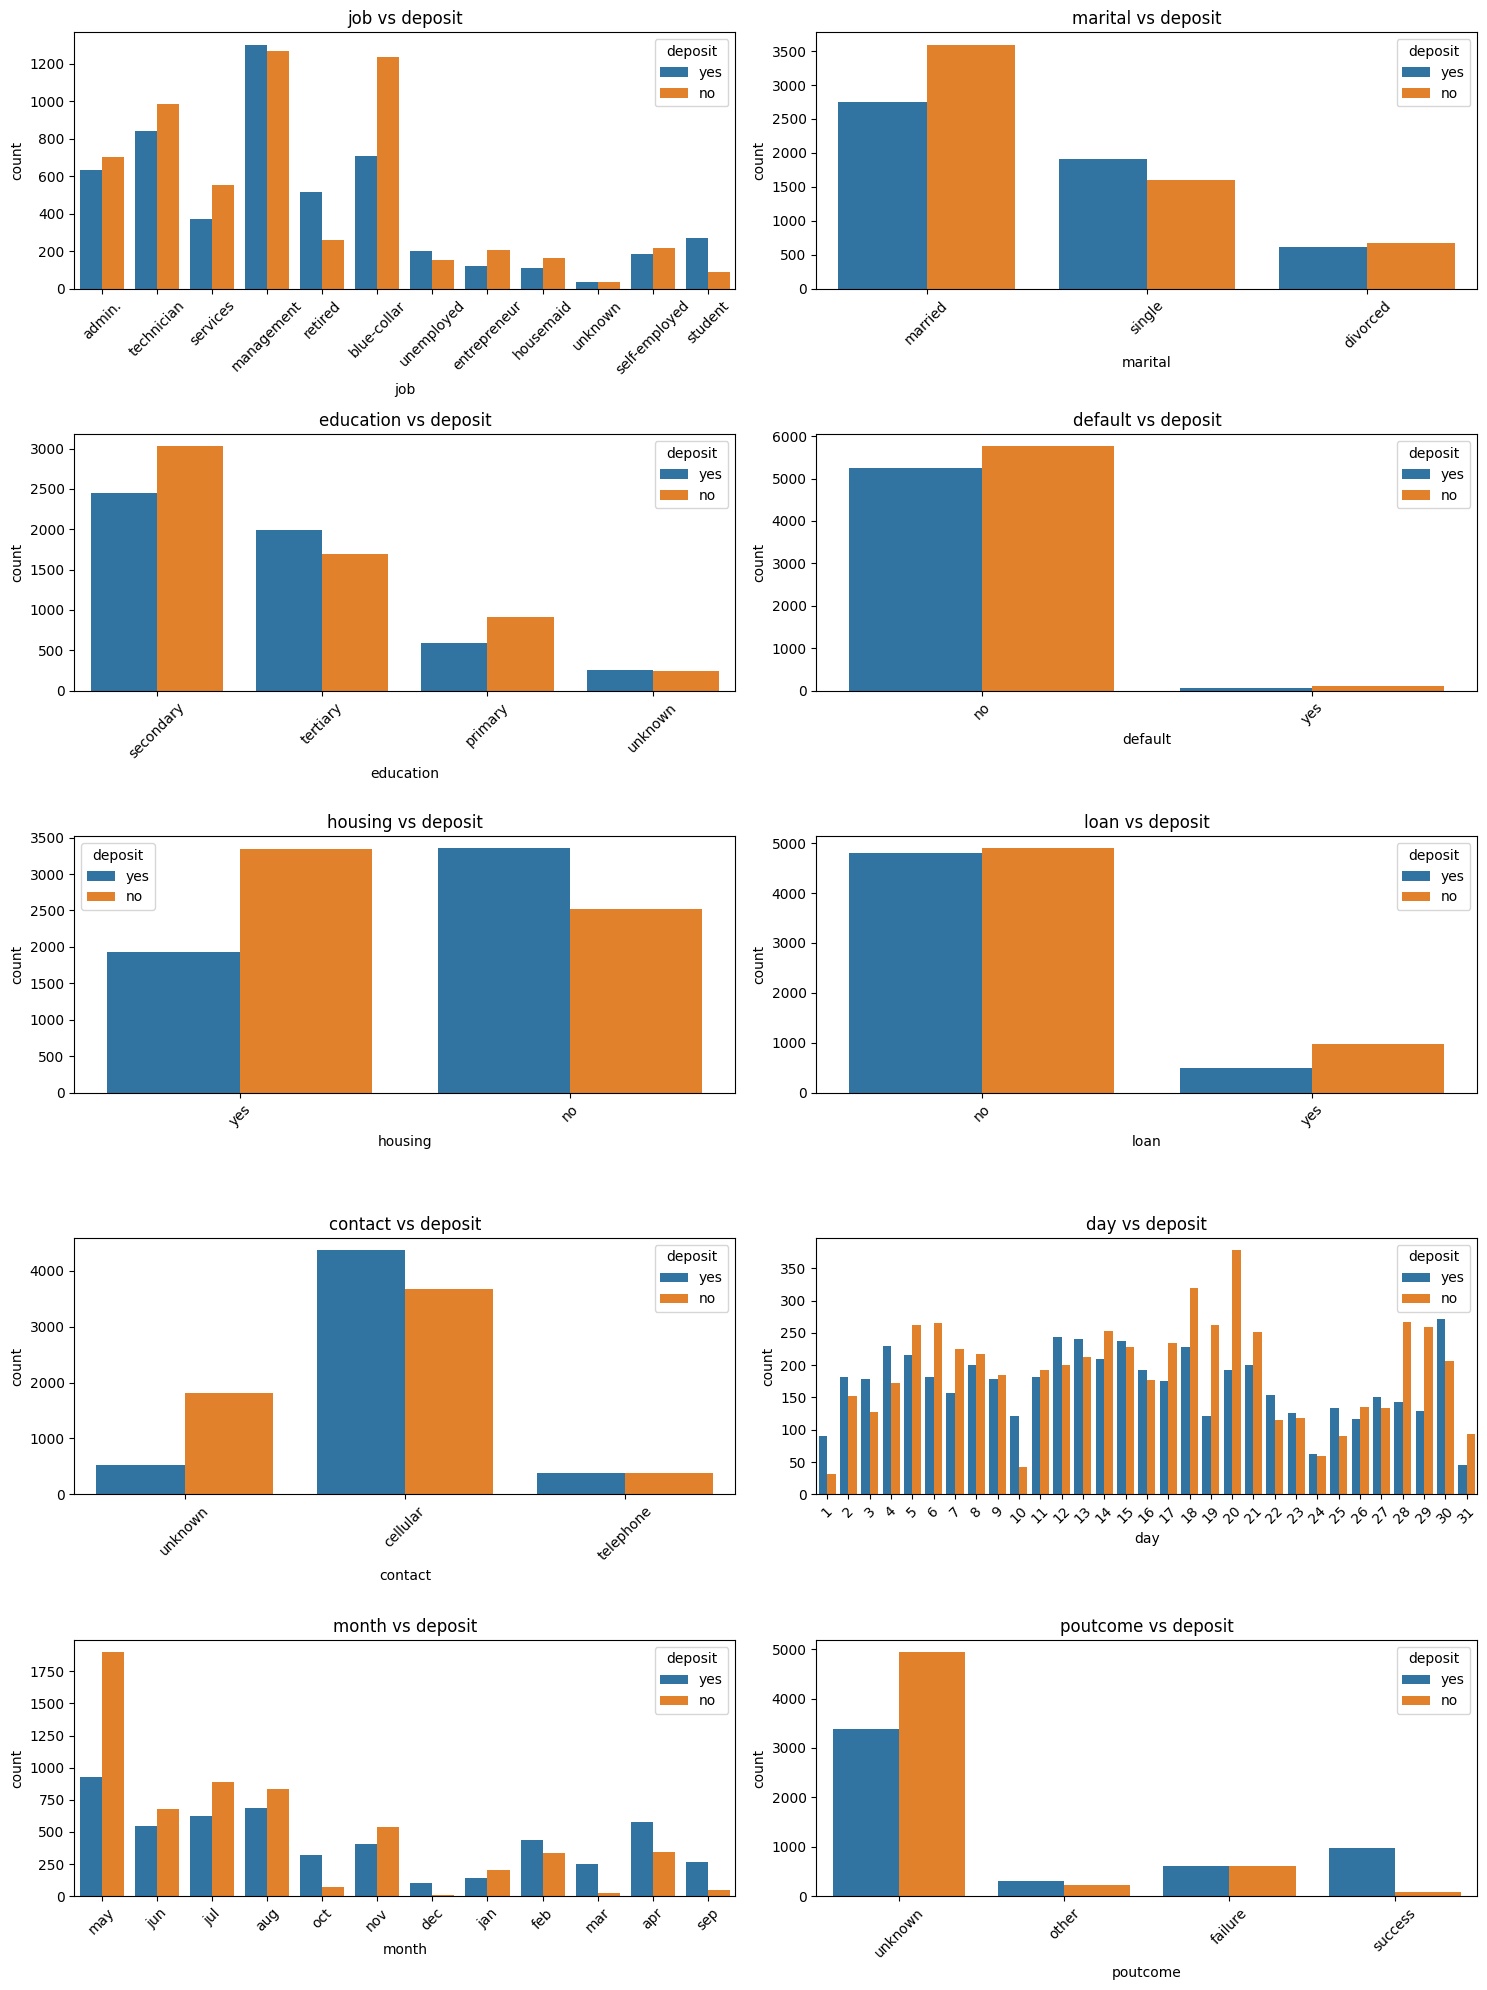

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for ax, feature in zip(axes.ravel(), categorical_features):
    sns.countplot(data=data, x=feature, hue="deposit", ax=ax)
    ax.set_title(f"{feature} vs deposit")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

Here we can derive a few insights from the visualizations:
- Clients with existing credits (`housing` and `loan`) are less likely to subscribe to a term deposit.
- Clients who previously subscribed to a term deposit (`poutcome`) are more likely to subscribe again. That said, the majority of clients have not been previously contacted, so this feature may not be very informative for our model.
- The duration of the last contact is much higher for clients who subscribed to a term deposit. However, as mentioned in the dataset description, this feature should be discarded for a realistic predictive model, since it is not known before a call is performed and it highly affects the target variable.
- The distribution of `balance` is also different for the two classes of the target variable, with clients who subscribed to a term deposit having a somewhat higher average balance. However, there are also some outliers in this feature, which may affect the performance of our model.
- Contact method also seems to have an impact on the target variable, with clients contacted via cellular being more likely to subscribe to a term deposit compared to those contacted via telephone. That said, there is also a significant proportion of missing values in this feature, which may affect its usefulness for our model. Also, cellular contact is more common in the dataset, so this feature may be somewhat imbalanced.

## Data preprocessing

Now that we have some understanding of the dataset, we can start with data preprocessing. We will create a pipeline to handle missing values, encode categorical features, and scale numerical features.

The first step is to separate the features and the target variable.

We will drop the `duration` feature as it is not known before a call is performed, and it highly affects the target variable, which would lead to an unrealistic predictive model. We are also dropping `pdays` and `poutcome` due to the high proportion of missing values, which may affect the performance of our model.

In [ ]:
x = data.drop(columns=["deposit", "duration", "pdays", "poutcome"])
y = data["deposit"]

Before defining the preprocessing pipeline, we will perform a few simple transformations to the features:
- We will convert the `month` feature to a numerical representation, since it is an ordinal feature with a clear order (January to December).
- We will manually transform any column with `yes` and `no` values to binary 1 and 0, respectively, to simplify the encoding process in our pipeline. This includes our target variable `deposit`, which we will transform to a binary variable as well.
- For `education` and `job` features, we will replace 'unknown' values with the most frequent category in each feature, since 'unknown' is not a meaningful category and it may affect the performance of our model.
- For `education` specifically, we will manually encode the categories (primary, secondary, tertiary) to preserve the ordinal nature of this feature, which may be useful for our model.

Since these transformations are simple and do not require fitting any parameters, we will perform them outside of our preprocessing pipeline for simplicity. However, in a real-world scenario, it would be better to include all transformations in the pipeline to ensure that they are applied consistently to both the training and testing data.

In [ ]:
y = y.map({"yes": 1, "no": 0})

x["month"] = x["month"].map({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
})

binary_columns = ["default", "housing", "loan"]
for col in binary_columns:
    x[col] = x[col].map({"yes": 1, "no": 0})

x["education"] = x["education"].replace("unknown", x["education"].mode()[0])
x["job"] = x["job"].replace("unknown", x["job"].mode()[0])

x["education"] = x["education"].map({
    'primary': 1,
    'secondary': 2,
    'tertiary': 3,
})

We can now split the dataset into training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Now, let's define our preprocessing pipeline. For numerical features, we will impute missing values with the median and apply a power transformation to reduce skewness. For categorical features, we will impute missing values with the most frequent category and apply one-hot encoding. We will also set `remainder="passthrough"` in the `ColumnTransformer` to ensure that any columns not specified in the transformers are passed through without transformation (in this case, there should not be any, but it's a good practice to include this parameter). Additionally, we will set `verbose_feature_names_out=False` to get more readable feature names after transformation.

In [ ]:
preprocessing = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("num", make_pipeline(SimpleImputer(strategy="median"), PowerTransformer()),
             ["age", "balance", "campaign", "previous"]),
            ("cat", make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")),
             ["marital", "contact", "job"])
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )
)

Let's transform the training data using our preprocessing pipeline and take a look at the transformed features. Note that the output of the `ColumnTransformer` will be a NumPy array, so we will convert it back to a DataFrame for better readability, using the feature names generated by the transformers.

In [ ]:
X_train = preprocessing.fit_transform(X_train)
feature_names = preprocessing.named_steps["columntransformer"].get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=feature_names)
X_train.head()

,age,balance,campaign,previous,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,...,job_services,job_student,job_technician,job_unemployed,education,default,housing,loan,day,month
0,-1.288254,1.440574,1.434931,1.830018,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,10.0,9.0
1,-0.526827,-0.307910,0.878943,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,21.0,8.0
2,0.715215,-0.381555,-1.041703,1.500969,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,10.0,11.0
3,1.047190,0.299080,-1.041703,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,15.0,12.0
4,1.047190,0.183543,0.878943,1.882117,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,11.0,11.0


Let's repeat the same transformation for the testing data. Note that we will use `transform` instead of `fit_transform` to ensure that the same transformations are applied to the testing data as were learned from the training data.

In [ ]:
X_test = preprocessing.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)
X_test.head()

,age,balance,campaign,previous,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,...,job_services,job_student,job_technician,job_unemployed,education,default,housing,loan,day,month
0,1.697695,-0.142732,-1.041703,-0.577272,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,7.0
1,-0.111115,0.184589,1.833573,-0.577272,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,16.0,6.0
2,-0.417067,1.220943,-1.041703,1.500969,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,14.0,5.0
3,0.643284,2.111136,0.275043,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0,8.0
4,-0.417067,0.130425,0.878943,-0.577272,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,12.0,5.0


## Model training and evaluation

Instructions: Complete this exercise by training a classification model on the preprocessed training data and evaluating its performance on the testing data using appropriate metrics such as accuracy, precision, recall, and F1-score.

Try with at least 3 different classification algorithms (e.g., Logistic Regression, Random Forest, Support Vector Machine) and compare their performance. For each of them, use GridSearchCV to find the best hyperparameters and report the results.

Lastly, compare the performance of the models and, for the best one (based on your chosen evaluation metric), display a confusion matrix and a classification report to analyze the results in more detail.

### Defining objective metrics

Se eligió el F1-score como métrica principal porque el dataset presenta un ligero desbalanceo de ~47% "yes" y ~53% "no" por lo que en el contexto de una campaña de marketing bancario, ambos tipos de error resultan costosos: los falsos negativos implican perder clientes que sí habrían suscrito, mientras que los falsos positivos generan gasto innecesario en llamadas a personas que no contratarán. El F1-score ofrece el mejor equilibrio entre precisión y recall, siendo más robusto que la accuracy ante desbalanceos leves

### Training and evaluating different models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#### Model 1 - []

In [ ]:
# Model 1: Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=2000)

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 50],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

grid_search_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train, y_train)

print("Mejor combinación Logistic Regression:", grid_search_lr.best_params_)
print("Best F1 (CV): {:.4f}".format(grid_search_lr.best_score_))

best_lr = grid_search_lr.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejor combinación Logistic Regression: {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 (CV): 0.6423


#### Model 2 - []

In [ ]:
# Model 2: Random Forest
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

print("Mejor combinación Random Forest:", grid_search_rf.best_params_)
print("Best F1 (CV): {:.4f}".format(grid_search_rf.best_score_))

best_rf = grid_search_rf.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Mejor combinación Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 (CV): 0.6846


#### Model 3 - []

In [ ]:
# Model 3: SVM
svm = SVC(random_state=42, probability=True)

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_svm.fit(X_train, y_train)

print("Mejor combinación SVM:", grid_search_svm.best_params_)
print("Best F1 (CV): {:.4f}".format(grid_search_svm.best_score_))

best_svm = grid_search_svm.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejor combinación SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best F1 (CV): 0.6668


### Comparing model performance

In [26]:
# Evaluación en conjunto de prueba + comparación de overfitting
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'SVM': best_svm
}

results = []

for name, model in models.items():
    # Predicciones
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Métricas en test
    acc = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test)
    rec = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)

    # Métrica en train (para detectar overfitting)
    f1_train = f1_score(y_train, y_pred_train)

    results.append({
        'Model': name,
        'Test Accuracy': round(acc, 4),
        'Test Precision': round(prec, 4),
        'Test Recall': round(rec, 4),
        'Test F1': round(f1_test, 4),
        'Train F1': round(f1_train, 4),
        'Overfitting Δ': round(f1_train - f1_test, 4)
    })

results_df = pd.DataFrame(results)
display(results_df.sort_values(by='Test F1', ascending=False))

,Model,Test Accuracy,Test Precision,Test Recall,Test F1,Train F1,Overfitting Δ
1,Random Forest,0.7318,0.7588,0.6429,0.6961,0.9724,0.2763
2,SVM,0.7282,0.7785,0.6026,0.6793,0.7529,0.0736
0,Logistic Regression,0.6897,0.6754,0.6748,0.6751,0.6469,-0.0282


### Best model analysis

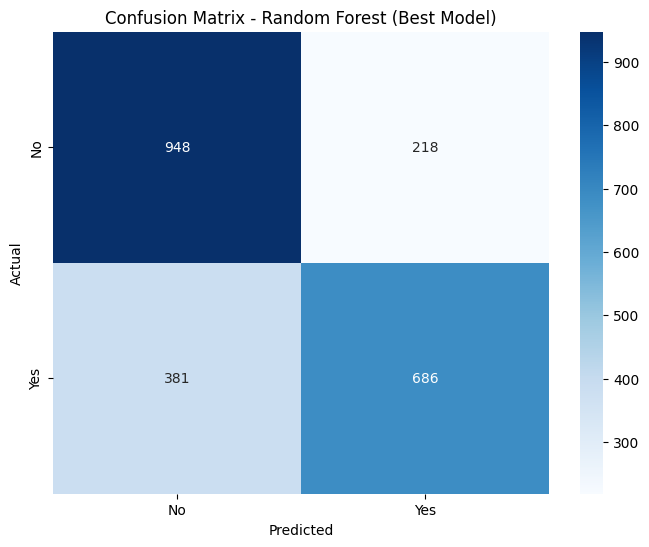

Classification Report - Random Forest
              precision    recall  f1-score   support

          No       0.71      0.81      0.76      1166
         Yes       0.76      0.64      0.70      1067

    accuracy                           0.73      2233
   macro avg       0.74      0.73      0.73      2233
weighted avg       0.74      0.73      0.73      2233



In [28]:
best_model = best_rf
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - Random Forest (Best Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report - Random Forest")
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

### Final remarks

El mejor modelo fue Random Forest, con un F1-score de 0.6961 en test. Logró precisión 0.7588 y recall 0.6429 en la clase "yes", superando claramente a SVM (F1 0.6793) y Logistic Regression (F1 0.6751). Aunque presenta algo de sobreajuste (Δ ≈ 0.28)